In [1]:
!pip install python_speech_features

In [2]:
!pip install sounddevice

In [3]:
!pip install pyaudio

In [1]:
pip install librosa scikit-learn python_speech_features sounddevice tqdm

Note: you may need to restart the kernel to use updated packages.


In [2]:
pip install sounddevice

Note: you may need to restart the kernel to use updated packages.


In [1]:
!pip install resampy

In [2]:
!pip install --upgrade librosa

In [3]:
import os
import librosa
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score
from python_speech_features import mfcc
from tqdm import tqdm
#import sounddevice as sd

In [4]:
import librosa
import numpy as np

# Function to extract MFCC features
def extract_mfcc_features(audio, sr=16000, num_cepstral=13, frame_length=0.02, frame_stride=0.02,
                           num_filters=32, fft_length=320, preemphasis_coeff=0.98):
    # Apply pre-emphasis
    audio = np.append(audio[0], audio[1:] - preemphasis_coeff * audio[:-1])

    # Compute the short-time Fourier transform (STFT)
    hop_length = int(frame_stride * sr)
    n_fft = fft_length
    window = "hann"  # You can choose a different window function if needed
    stft_result = librosa.core.stft(audio, hop_length=hop_length, n_fft=n_fft, window=window)

    # Compute the mel spectrogram
    mel_spectrogram = librosa.feature.melspectrogram(S=np.abs(stft_result)**2, sr=sr, n_mels=num_filters)

    # Logarithm of the mel spectrogram
    log_mel_energy = np.log(mel_spectrogram + 1e-9)

    # Extract MFCC features using DCT
    mfcc_features = librosa.feature.mfcc(S=log_mel_energy, n_mfcc=num_cepstral)

    # Apply mean and variance normalization across time
    mfcc_features = librosa.util.normalize(mfcc_features, norm=2, axis=0, fill=True)

    return mfcc_features

In [5]:
import os
from pydub import AudioSegment

def collect_noisedata(input_folder,output_folder):
    # Ensure the output folder exists
    none_folder = os.path.join(output_folder, 'none')
    if not os.path.exists(none_folder):
        os.makedirs(none_folder)

    # Iterate through each file in the input folder
    for root, _, files in os.walk(input_folder):
        for filename in files:
            if filename.endswith(".wav"):  # Adjust the file extension if needed
                # Load the audio file
                audio = AudioSegment.from_file(os.path.join(root, filename))

                # Extract the first and second seconds separately
                first_second = audio[:1000]
                second_second = audio[1000:2000]

                # Save the first second audio to the "none" folder
                output_filename_1 = os.path.join(none_folder, f"{filename[:-4]}_first_second.wav")
                first_second.export(output_filename_1, format="wav")

                # Save the second second audio to the "none" folder
                output_filename_2 = os.path.join(none_folder, f"{filename[:-4]}_second_second.wav")
                second_second.export(output_filename_2, format="wav")

/Users/doctorranjan/anaconda3/lib/python3.10/site-packages/pydub/utils.py:170: RuntimeWarning: Couldn't find ffmpeg or avconv - defaulting to ffmpeg, but may not work
  warn("Couldn't find ffmpeg or avconv - defaulting to ffmpeg, but may not work", RuntimeWarning)


In [6]:
def preprocess_data(data_dir):
    data = []
    labels = []
    features = []

    for class_label in os.listdir(data_dir):
        class_path = os.path.join(data_dir, class_label)
        for file_name in tqdm(os.listdir(class_path), desc=f"Processing {class_label}"):
            file_path = os.path.join(class_path, file_name)
            audio, _ = librosa.load(file_path, sr = 16000)

            # Simply append the raw audio data to the dataset
            data.append({
                'audio': audio,
                'label': class_label
            })
            mfcc_features = extract_mfcc_features(audio)
            features.append(mfcc_features)
            labels.append(class_label)

    features = np.array(features)
    labels = np.array(labels)
    classes = set(labels)

     #Split the data into training and testing sets
    X_train, X_test, y_train, y_test = train_test_split(features, labels, test_size=0.2, random_state=42)

    return features ,classes ,(X_train, y_train), (X_test, y_test)
# Example usage
data_dir = "/Users/doctorranjan/Desktop/yp/hackathon/Dataset"
collect_noisedata("/Users/doctorranjan/Desktop/yp/hackathon/noisedata","data_dir")

In [11]:
import tensorflow as tf
from tensorflow.keras.layers import Input, Reshape, LSTM, Dropout, Flatten, Dense
from tensorflow.keras.optimizers import Adam
from sklearn.preprocessing import LabelEncoder
from tensorflow.keras import regularizers
import numpy as np


def train_model(X_train, y_train, num_classes, X_test, y_test):
    encoder = LabelEncoder()
    encoded_labels_train = encoder.fit_transform(y_train)
    encoded_labels_test = encoder.transform(y_test)
    
    # Add 'None' class to the list of classes
    classes_with_none = np.append(encoder.classes_, 'None')
    
    # Fit label encoder with the extended list of classes
    encoder.fit(classes_with_none)
    
    # Transform labels to include 'None'
    encoded_labels_train = encoder.transform(y_train)
    encoded_labels_test = encoder.transform(y_test)
    
    model = tf.keras.Sequential([
        Input(shape=(X_train.shape[1], X_train.shape[2])),
        Reshape((13, -1)),
        LSTM(64, activation='relu', kernel_regularizer=regularizers.l2(0.01), return_sequences=True),
        Dropout(0.2),
        Flatten(),
        Dense(num_classes, activation='sigmoid')])
    
    model.compile(optimizer=Adam(learning_rate=0.01), loss='sparse_categorical_crossentropy', metrics=['accuracy'])
    model.fit(X_train, encoded_labels_train, epochs=50, batch_size=32, validation_data=(X_test, encoded_labels_test))
    
    return model, encoder

# Assuming you have features, classes, (X_train, y_train), (X_test, y_test) from preprocess_data
# Ensure that your labels include a "None" class
features, classes, (X_train, y_train), (X_test, y_test) = preprocess_data(data_dir)
num_classes = len(classes) + 1  # Add 1 for the "None" class

# Train the model
model, encoder = train_model(X_train, y_train, num_classes, X_test, y_test)


Processing door_close: 100%|███████████████| 3503/3503 [00:30<00:00, 114.70it/s]


Epoch 1/50
317/317 [==============================] - 13s 22ms/step - loss: 0.9492 - accuracy: 0.5903 - val_loss: 0.6960 - val_accuracy: 0.7353
Epoch 2/50
317/317 [==============================] - 4s 14ms/step - loss: 0.6122 - accuracy: 0.7906 - val_loss: 0.4587 - val_accuracy: 0.8785
Epoch 3/50
317/317 [==============================] - 4s 13ms/step - loss: 0.4899 - accuracy: 0.8551 - val_loss: 0.4257 - val_accuracy: 0.8959
Epoch 4/50
317/317 [==============================] - 4s 12ms/step - loss: 0.4336 - accuracy: 0.8747 - val_loss: 0.4424 - val_accuracy: 0.8556
Epoch 5/50
317/317 [==============================] - 4s 12ms/step - loss: 0.3917 - accuracy: 0.8952 - val_loss: 0.3266 - val_accuracy: 0.9168
Epoch 6/50
317/317 [==============================] - 4s 14ms/step - loss: 0.4074 - accuracy: 0.8922 - val_loss: 0.3283 - val_accuracy: 0.9164
Epoch 7/50
317/317 [==============================] - 4s 14ms/step - loss: 0.3554 - accuracy: 0.9043 - val_loss: 0.3641 - val_accuracy: 0.905

80/80 [==============================] - 1s 5ms/step
Accuracy: 93.37%
Precision: 93.48%
Recall: 93.37%
F1 Score: 93.35%


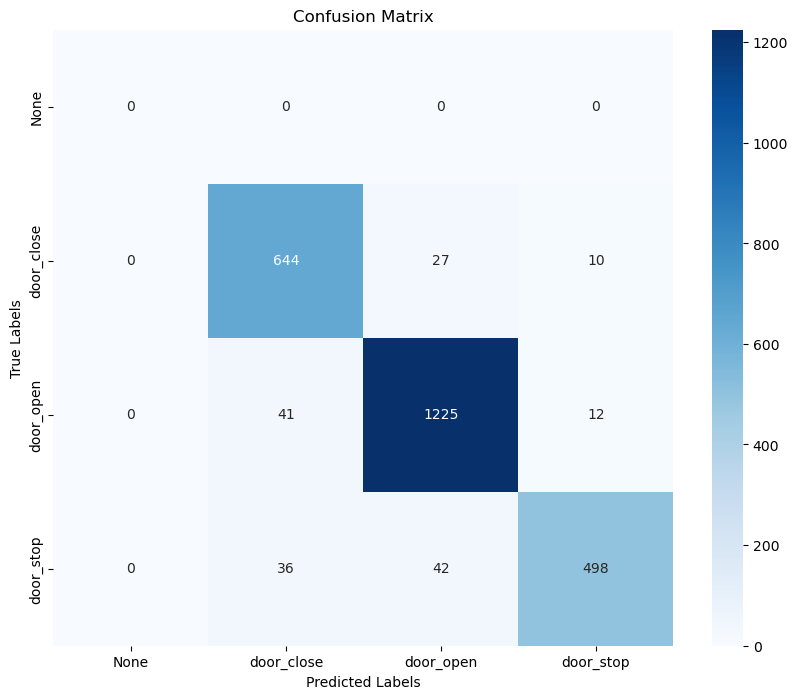

In [12]:
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

# Function to calculate and print multiple evaluation metrics
def evaluate_model(model, X_test, y_test, label_encoder):
    # Predictions on test set
    y_pred = model.predict(X_test)
    

    # Convert predictions to class labels
    y_pred_labels = label_encoder.inverse_transform(np.argmax(y_pred, axis=1))

    # Calculate and print accuracy
    accuracy = accuracy_score(y_test, y_pred_labels)
    print(f'Accuracy: {accuracy * 100:.2f}%')

    # Calculate and print precision, recall, and F1 score
    precision = precision_score(y_test, y_pred_labels, average='weighted')
    recall = recall_score(y_test, y_pred_labels, average='weighted')
    f1 = f1_score(y_test, y_pred_labels, average='weighted')

    print(f'Precision: {precision * 100:.2f}%')
    print(f'Recall: {recall * 100:.2f}%')
    print(f'F1 Score: {f1 * 100:.2f}%')

    # Generate and plot confusion matrix
    cm = confusion_matrix(y_test, y_pred_labels, labels=label_encoder.classes_)
    plt.figure(figsize=(10, 8))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=label_encoder.classes_, yticklabels=label_encoder.classes_)
    plt.title('Confusion Matrix')
    plt.xlabel('Predicted Labels')
    plt.ylabel('True Labels')
    plt.show()

# Assuming you have the trained_model, X_test, y_test, and label_encoder
evaluate_model(model, X_test, y_test, encoder)


In [13]:
model.save('models/LSTM_with_none_trial_model.h5')